# Kristijono Donelaičio 'Metų' hegzametras

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tabulate
from  matplotlib.ticker import FuncFormatter
import os
from pathlib import Path

sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")
cm = plt.cm.YlOrRd
sns.color_palette("YlOrRd")

subdirectory = Path("assets")
subdirectory.mkdir(exist_ok=True)

def write_figure(the_name):
    plt.savefig(subdirectory / f"figure-{the_name}.svg")

def write_table(df, the_name, caption="", heatmap=False, axis=None):
    style = df.style if not heatmap else df.style.background_gradient(axis=axis, cmap=cm)
    with (subdirectory / f"table-{the_name}.tex").open(mode="w") as f:
        f.write(
            (style).highlight_null(props="background-color:white; color:white;").to_latex(
                convert_css=True, 
                hrules=True,
                sparse_index=False,
                environment="longtable", 
                position="!hbt", 
                caption=caption, 
                label="tbl:"+the_name
            )
        )
    with (subdirectory / f"table-{the_name}.html").open(mode="w") as f:
        f.write((style).highlight_null(props="opacity:0").to_html(sparse_index=False))
    with (subdirectory / f"table-{the_name}.md").open(mode="w") as f:
        if caption:
            f.write(f"Table: {caption}\n\n")
        f.write(df.to_markdown(floatfmt=".2f").replace("nan", "\u00a0").replace(".00", "   ").replace(".", ",")) #make nan invisible

In [22]:
all_caesuras = ["3h", "5h", "7h", "bd"]
df = pd.read_csv(os.getenv("EPIC_CSV") or "./metai-scansion.csv")
print(len(df))

2968


In [23]:
incorrect_lines = df[df.isnull()["scansion"]]
df = df.dropna()
print(len(incorrect_lines))
incorrect_lines

5


,id,book,verse,text,words,wordSyllables,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
189,PL_5r_24_190,1,190,"sykeis vargstantiems, néy kôks gĕrădėjas,",5,2.3.1.1.4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,×××××××⏑⏑××,NaN,×××××––××××,NaN,⏑––––––⏑⏑––,NaN
477,PL_8v_12_478,1,478,"taigĭ nŭtvérkim jau kiekviens săvŏ iáuti̷,",6,2.3.1.2.2.2,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,×⏑⏑×××××⏑⏑××,NaN,××⏑–⏑×××××–⏑,NaN,–⏑⏑–––––⏑⏑––,NaN
1093,RG_54_20_434,3,434,"mùms kasdien ir taìp dosnaý dŏvănója,",6,1.2.1.1.2.4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,×××××××⏑⏑××,NaN,–×××–⏑–⏑⏑–⏑,NaN,–⏑–––⏑–⏑⏑–⏑,NaN
1594,WD_15r_23_23,2,23,bet sù koynù kasdien dangaus ĭssĭgâsta!,6,1.1.2.2.2.4,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,××××××××⏑⏑××,NaN,×–⏑–××××⏑⏑–⏑,NaN,–⏑–⏑⏑––––⏑–⏑,NaN
2523,ZR_92_19_238,4,238,"taìp kad jós smarkùms, tamsój păsĭkėlęs,",6,1.1.1.2.2.4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,×××××××⏑⏑××,NaN,–×–⏑–⏑–××××,NaN,–––––––⏑⏑––,NaN


In [24]:
ambiguous = df["scansion"].str.contains(r'\|')
ambiguous_lines = df[ambiguous]
df = df[~ambiguous]

In [25]:
print(len(ambiguous_lines))
print(len(df))
for _, row in ambiguous_lines.iterrows():
    print(str(row["book"]) + "." + str(row["verse"]) + " (" + row["scansion"].replace("|", "/") + ")", end=", ")

1
2962
2.117 (DDDSSS/DDSDSS), 

In [26]:
# convert data types
df["scansion"] = pd.Categorical(df["scansion"], sorted(df["scansion"].drop_duplicates().values, key=lambda x: x.count("S")*2 + x.count("D")*3))

#for caesura in all_caesuras:
#    df[caesura] = df[caesura].map({"True": True, "False": False})

for column in ["stressConflict", "metreConflict", "weightConflict", "syllables", "words"]:
    df[column] = df[column].astype(int)

In [27]:
len(df)

2962

## How well does the analysis match the syllables?

In [28]:
pd.set_option("styler.format.precision", 0)
conflicts = df[["metreConflict", "stressConflict", "weightConflict"]].apply(pd.Series.value_counts)
conflicts.index = conflicts.index.rename("Konflikte")
conflicts = conflicts.rename({"metreConflict": "Markierung", "stressConflict": "Wortakzent", "weightConflict": "Silbengewicht"}, axis="columns")
write_table(conflicts, "conflicts", caption="Konflikte zwischen der Analyse und den metrischen Markierungen, dem Wortakzent und dem Silbengewicht")
pd.set_option("styler.format.precision", 2)
conflicts

,Markierung,Wortakzent,Silbengewicht
Konflikte,,,
0,2959.0,2243.0,852
1,3.0,661.0,1097
2,NaN,52.0,706
3,NaN,5.0,227
4,NaN,1.0,66
5,NaN,NaN,13
6,NaN,NaN,1


In [29]:
print(df.metreConflict.astype(int).sum(), df.stressConflict.astype(int).sum(), df.weightConflict.astype(int).sum())


3 784 3525


In [30]:
# df["weightConflict"].astype(int).value_counts(
df[df["weightConflict"] >= 5]

,id,book,verse,text,words,wordSyllables,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
10,PL_3r_11_11,1,11,ar po sàvŏ kĕrrù pèr žiema̷ bùvŏ miĕgo...,8,1.1.2.2.1.2.2.3,14,SDSSDS,Nothing,Just Unmarked,Nothing,Nothing,Nothing,Just Unmarked,×××⏑⏑×××××⏑⏑××,0,××–⏑⏑––××–⏑⏑–⏑,0,–⏑⏑⏑–⏑–––⏑⏑–––,5
193,PL_5r_28_194,1,194,"àr sù próvita pučkà tikt mùšă tĭkt mùša,",8,1.1.3.2.1.2.1.2,13,SSSSDS,Nothing,Just Unmarked,Nothing,Just Unmarked,Nothing,Just Unmarked,×××××××××⏑⏑××,0,–––⏑⏑⏑–×–⏑×–⏑,1,–⏑–⏑⏑–⏑–⏑⏑–⏑⏑,5
231,PL_5v_24_232,1,232,bèt dâr tai nĕ gănà: jis viss pĭnnĭ̷gu ...,9,1.1.1.1.2.1.1.3.3,14,SDSDSS,Just Unmarked,Just Marked,Nothing,Just Unmarked,Nothing,Nothing,×××⏑⏑×××⏑⏑××××,0,––××⏑–××××××××,0,–––⏑⏑⏑––––⏑–⏑–,5
250,PL_5v_43_251,1,251,"mislija, kàd kóžnas pônas puikey ĭssĭrėde̷s",6,3.1.2.2.2.4,14,SSSDDS,Just Marked,Nothing,Nothing,Nothing,Just Unmarked,Nothing,××××××××××⏑⏑××,0,×××––⏑–⏑××××××,0,⏑⏑⏑––––––––⏑––,5
266,PL_6r_16_267,1,267,o momà sù̆ răžù sùpykus mùšĕ pĕr ausi̷.,8,1.2.1.2.3.2.1.2,14,SDSSDS,Just Unmarked,Just Unmarked,Nothing,Nothing,Nothing,Just Unmarked,×××⏑⏑×××××⏑⏑××,0,×⏑––⏑––⏑⏑–⏑×××,2,⏑⏑⏑⏑⏑⏑⏑⏑–⏑⏑–––,6
363,PL_7r_25_364,1,364,tù sù sàvŏ iĕvà sodè pavásărĭ šve̷sd...,7,1.1.2.2.2.4.2,14,SDSSDS,Nothing,Just Unmarked,Nothing,Just Unmarked,Nothing,Nothing,×××⏑⏑×××××⏑⏑××,0,–––⏑⏑–⏑–⏑–⏑⏑××,0,⏑⏑⏑⏑–⏑⏑⏑⏑–⏑⏑––,5
378,PL_7r_40_379,1,379,tù sù sàvŏ iė̆và jùk dâr nè bùvŏtă...,9,1.1.2.2.1.1.1.3.2,14,SDSSDS,Nothing,Just Unmarked,Nothing,Just Unmarked,Nothing,Just Unmarked,×××⏑⏑×××××⏑⏑××,0,–––⏑⏑–––––⏑⏑××,0,⏑⏑⏑⏑–⏑––⏑⏑⏑⏑––,5
804,RG_38_36_145,3,145,àlĕ žą̆sú bei vìštu vós vienà păsĭlìko.,7,2.2.1.2.1.2.4,14,DSSSDS,Just Unmarked,Nothing,Nothing,Just Unmarked,Nothing,Nothing,×⏑⏑×××××××⏑⏑××,0,–⏑⏑–×–⏑–⏑–⏑⏑–⏑,0,⏑⏑–––⏑⏑––⏑⏑⏑⏑⏑,5
833,RG_40_25_174,3,174,"nės jie mìslyjo, kad búrs, pas krìzą̆ sė...",8,1.1.3.1.1.1.2.3,13,SSSSDS,Nothing,Just Marked,Nothing,Just Marked,Nothing,Just Unmarked,×××××××××⏑⏑××,0,××–⏑⏑×–×–⏑×××,1,––⏑⏑⏑–––⏑––––,5
1149,RG_56_38_490,3,490,"ìr kad ùrdĕlį̇̆ ništaisiaù, tuo mùšė̆ p...",8,1.1.3.3.1.2.1.2,14,SDSSDS,Nothing,Nothing,Nothing,Just Marked,Nothing,Just Unmarked,×××⏑⏑×××××⏑⏑××,0,–×–⏑⏑⏑⏑–×–⏑×–⏑,1,–––⏑–⏑–––⏑––––,5


In [31]:
df[(df["stressConflict"] >= 3) & (df["weightConflict"] >= 3)]

,id,book,verse,text,words,wordSyllables,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
133,PL_4v_10_134,1,134,"tù nè lúbiji pyragû neigĭ răgaišiû,",6,1.1.3.3.2.3,13,SSSSDS,Nothing,Just Unmarked,Nothing,Nothing,Nothing,Just Unmarked,×××××××××⏑⏑××,0,–––⏑⏑⏑⏑–××⏑⏑–,3,⏑⏑–⏑⏑⏑⏑––⏑⏑––,3


## Amount of syllables

In [32]:
syllables_per_word = df["syllables"].sum() / df.words.sum()
syllables_per_word

1.9891466693219158

In [33]:
syllables_per_verse = df["syllables"].mean()
print(df.syllables.std())
syllables_per_verse

0.6445501516649472


13.48885887913572

In [34]:
# syll / words
syls_per_words = (df.groupby("book")["syllables"].sum() / df.groupby("book")["words"].sum()).rename("Silben / Wort")
average_sylls = df.groupby("book")["syllables"].mean().rename("μ Silben")
stddev_sylls = df.groupby("book")["syllables"].std().rename("σ Silben")
df_syllables = pd.concat([syls_per_words, average_sylls, stddev_sylls], axis=1)
df_syllables.index = df_syllables.index.rename("Buch")
write_table(df_syllables, "syllables", caption="Silben pro Wort und Silben pro Vers")
df_syllables

,Silben / Wort,μ Silben,σ Silben
Buch,,,
1,1.964734,13.547112,0.685842
2,1.973684,13.483146,0.645004
3,2.025450,13.453348,0.609240
4,1.981873,13.486050,0.646390


In [35]:
syllable_per_book = pd.crosstab(df["book"].rename("Buch"), df["syllables"].rename("Anzahl Silben"))
write_table(syllable_per_book, "syllable-per-book", caption="Häufigkeit der Silbenzahlen pro Buch")
syllable_per_book

Anzahl Silben,13,14,15,16,17
Buch,,,,,
1,365,231,58,3,1
2,416,257,32,5,2
3,549,315,44,2,1
4,397,245,33,4,2


In [36]:
df_syllables["Silben / Wort"].std()

0.026935143685459705

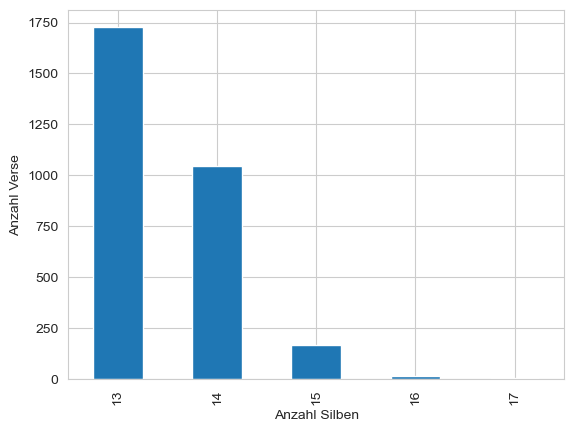

In [50]:
df["syllables"].value_counts().plot.bar(xlabel="Anzahl Silben", ylabel="Anzahl Verse")
write_figure("syllable-count-histogram-simple")

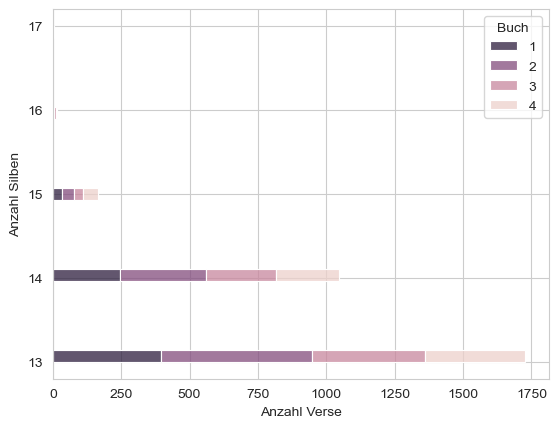

In [40]:
# syllable count histogram
ax = sns.histplot(y="syllables", data=df, hue="book", multiple="stack")
ax.set(ylabel='Anzahl Silben', xlabel='Anzahl Verse')
ax.legend(title="Buch", labels=[1,2,3,4])
ax.set_yticks(sorted(list(df["syllables"].drop_duplicates().values)))
write_figure("syllable-count-histogram")

In [18]:
df_syllables_count = pd.DataFrame(df["syllables"].rename(index="Silbenzahl").value_counts()).rename(columns={"count": "Anzahl Verse"})
df_syllables_count["Anteil Verse/\\%"] = 100 * df_syllables_count["Anzahl Verse"] / len(df)
write_table(df_syllables_count, "syllable-count", caption="Häufigkeit der einzelnen Silbenzahlen")
df_syllables_count

,Anzahl Verse,Anteil Verse/\%
Silbenzahl,,
13,1727,58.305199
14,1048,35.381499
15,167,5.638082
16,14,0.472654
17,6,0.202566


## Scansion

In [19]:
df_scansion_per_book = pd.crosstab(df["scansion"].rename("Hexametertyp"), df["book"].rename("Buch"))
write_table(df_scansion_per_book, "scansion-per-book", caption="Häufigkeit der Hexameter-Typen pro Buch")
df_scansion_per_book

Buch,1,2,3,4
Hexametertyp,,,,
SSSSDS,360,408,541,392
SSSDSS,5,8,8,5
SSSDDS,33,31,57,35
SSDSDS,33,38,43,31
DSSSDS,105,112,142,108
SDSSDS,57,74,69,66
SDSDSS,2,0,0,1
DSSDSS,1,2,3,2
SSDDSS,0,0,1,2


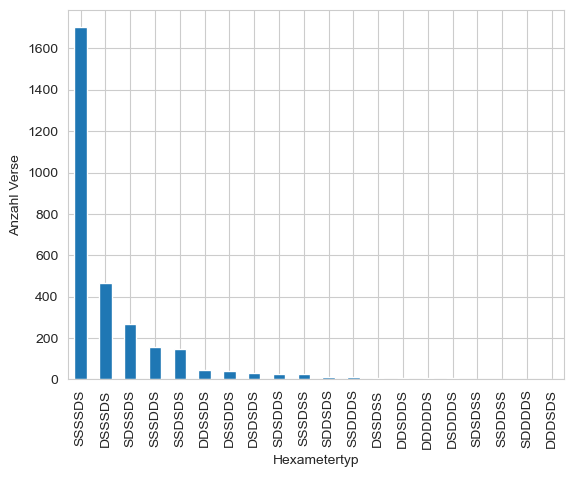

In [49]:
df["scansion"].value_counts().plot.bar(xlabel="Hexametertyp", ylabel="Anzahl Verse")
write_figure("scansion-histogram-simple")

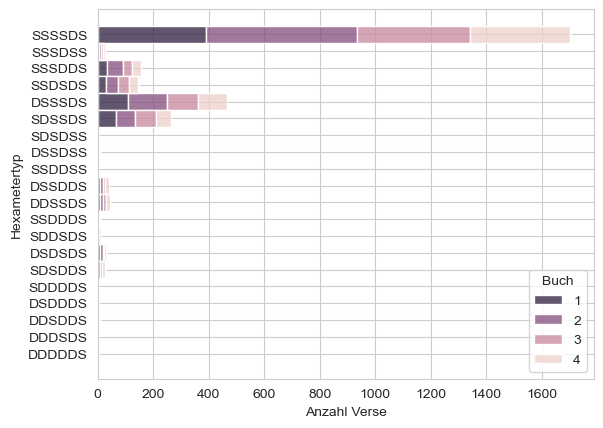

In [20]:
ax = sns.histplot(y="scansion", data=df, hue="book", multiple="stack")
ax.set(ylabel='Hexametertyp', xlabel='Anzahl Verse')
ax.legend(title="Buch", labels=[1,2,3,4])
write_figure("scansion-histogram")

In [21]:
pd.set_option("styler.format.precision", 2)
spondees_dactyls = pd.DataFrame()
spondees_dactyls["Buch"] = df["book"]
spondees_dactyls["S"] = df["scansion"].str.count("S")
spondees_dactyls["D"] = df["scansion"].str.count("D")
print(spondees_dactyls.sum(), spondees_dactyls.sum().D / (spondees_dactyls.sum().D + spondees_dactyls.sum().S))
df_s_d = spondees_dactyls.groupby("Buch").sum()
df_s_d["Anteil D/\\%"] = df_s_d["D"] / (df_s_d["S"] + df_s_d["D"])
write_table(df_s_d, "dactyls-spondees", caption="Daktylen vs. Spondeen")
df_s_d

Buch     7539
S       13362
D        4410
dtype: int64 0.24814314652261985


,S,D,Anteil D/\%
Buch,,,
1,2930,1018,0.257852
2,3216,1056,0.247191
3,4142,1324,0.242225
4,3074,1012,0.247675


In [22]:
df_scansion = pd.DataFrame(df["scansion"].rename(index="Hexametertyp").value_counts()).rename(columns={"count": "Anzahl Verse"})
df_scansion["Anteil Verse/\\%"] = 100 * df_scansion["Anzahl Verse"] / len(df)
write_table(df_scansion, "scansion-types", caption="Häufigkeit einzelner Hexameter-Typen")
df_scansion[0:10]

,Anzahl Verse,Anteil Verse/\%
Hexametertyp,,
SSSSDS,1701,57.427414
DSSSDS,467,15.766374
SDSSDS,266,8.980419
SSSDDS,156,5.266712
SSDSDS,145,4.895341
DDSSDS,46,1.553005
DSSDDS,40,1.350439
DSDSDS,32,1.080351
SDSDDS,27,0.911546


In [23]:
spondiaci = df[df["scansion"].str.endswith("SS")]
print(len(spondiaci), 100 * len(spondiaci) / len(df))

40 1.350438892640108


In [24]:
hexameter_types = df.scansion.drop_duplicates().values
print(hexameter_types)
print([htype for htype in hexameter_types if htype.endswith("SS")])

['SSSDDS', 'SSSSDS', 'SSDSDS', 'DSSSDS', 'SDSSDS', ..., 'DSSDSS', 'DDDDDS', 'DDSDDS', 'SSDDSS', 'DDDSDS']
Length: 20
Categories (20, object): ['SSSSDS', 'SSSDSS', 'SSSDDS', 'SSDSDS', ..., 'DSDDDS', 'DDSDDS', 'DDDSDS', 'DDDDDS']
['SSSDSS', 'SDSDSS', 'DSSDSS', 'SSDDSS']


In [25]:
pd.crosstab(df['scansion'].rename("Hexametertyp"), df['syllables'].rename("Silbenzahl"))

Silbenzahl,13,14,15,16,17
Hexametertyp,,,,,
SSSSDS,1701,0,0,0,0
SSSDSS,26,0,0,0,0
SSSDDS,0,156,0,0,0
SSDSDS,0,145,0,0,0
DSSSDS,0,467,0,0,0
SDSSDS,0,266,0,0,0
SDSDSS,0,3,0,0,0
DSSDSS,0,8,0,0,0
SSDDSS,0,3,0,0,0


In [26]:
strange_verses = df[df["scansion"].str.endswith("SSS")][["book", "verse", "text", "scansion"]]
write_table(strange_verses, "strange-verses")
strange_verses

,book,verse,text,scansion


## Caesurae

### Caesuras per book

In [55]:
caesuras_marked_count = pd.DataFrame(df, columns=all_caesuras).apply(pd.Series.value_counts)

caesuras_marked_count

,3h,5h,7h,bd
Just Unmarked,1437,1675,1604,1599
Nothing,1280,679,1155,1288
Just Marked,245,608,203,75


In [56]:
caesura_rows = []
for index, row in df.iterrows():
    for caesura in all_caesuras:
        if row[caesura].startswith("Just"):
            caesura_rows.append([row["book"], row["verse"], caesura])
caesura_df = pd.DataFrame(caesura_rows, columns=["book", "verse", "caesura"])
caesura_df["caesura"] = pd.Categorical(caesura_df["caesura"], all_caesuras)

In [57]:
caesura_per_book = pd.crosstab(caesura_df["book"].rename("Buch"), caesura_df["caesura"].rename("Einschnitt"))
write_table(caesura_per_book, "caesura-per-book", caption="Häufigkeit einzelner Verseinschnitte (pro Buch)")
caesura_per_book

Einschnitt,3h,5h,7h,bd
Buch,,,,
1,384,495,395,390
2,398,552,432,395
3,526,706,550,516
4,374,530,430,373


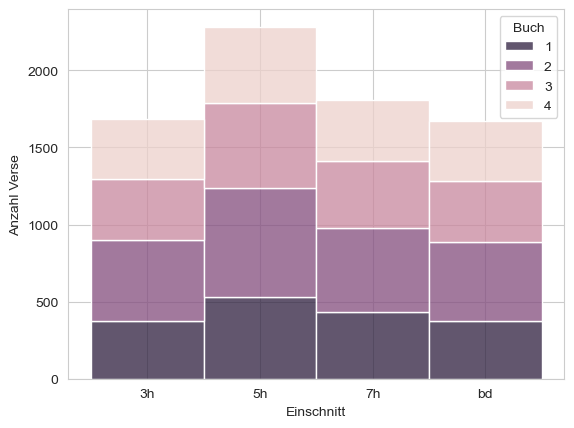

In [58]:
ax = sns.histplot(x="caesura", data=caesura_df, hue="book", multiple="stack")
ax.set(xlabel='Einschnitt', ylabel='Anzahl Verse')
ax.legend(title="Buch", labels=[1,2,3,4])
write_figure("caesura-histogram")

In [59]:
reslut = []
for s in all_caesuras:
    count = df[s].value_counts().sum() - df[s].value_counts()["Nothing"]
    reslut.append([count, 100 * count / len(df)])
caesura_count = pd.DataFrame(reslut, columns=["Anzahl Verse", "Anteil/\\%"])
caesura_count.index = all_caesuras
caesura_count = caesura_count.sort_values("Anzahl Verse", ascending=False)
caesura_count.index = caesura_count.index.rename("Einschnitt")
write_table(caesura_count, "caesura-count", caption="Häufigkeit einzelner Verseinschnitte")
caesura_count

,Anzahl Verse,Anteil/\%
Einschnitt,,
5h,2283,77.076300
7h,1807,61.006077
3h,1682,56.785955
bd,1674,56.515868


### Caesura-less lines

In [60]:
caesuraless = df[
    (df["3h"]=="Nothing") & 
    (df["5h"]=="Nothing") & 
    (df["7h"]=="Nothing") & 
    (df["bd"]=="Nothing")
]
write_table(caesuraless, "caesuraless")
caesuraless

,id,book,verse,text,words,wordSyllables,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
503,PL_8v_38_505,1,505,ir mĕsĭninkui spránda̷ tàvŏ nŭsùkt nŭg...,6,1.4.2.2.2.4,15,DSSDDS,Nothing,Nothing,Nothing,Nothing,Just Unmarked,Nothing,×⏑⏑×××××⏑⏑×⏑⏑××,0,×××××–⏑–⏑⏑–⏑⏑–⏑,0,–⏑⏑––––⏑⏑⏑–⏑⏑–⏑,1
681,RG_32_24_22,3,22,"àk, kur dìngot giedros júsgĭ păvásăriŏ...",7,1.1.2.2.2.4.2,14,SSSDDS,Nothing,Nothing,Nothing,Nothing,Just Unmarked,Nothing,×××××××⏑⏑×⏑⏑××,0,–×–⏑××–⏑⏑–⏑⏑××,0,–––––––⏑⏑–⏑–––,1
715,RG_34_22_56,3,56,"jús kvietkélės jáunos, júsgĭ păvásări...",6,1.3.2.2.4.2,14,SSSDDS,Nothing,Nothing,Nothing,Nothing,Just Unmarked,Nothing,×××××××⏑⏑×⏑⏑××,0,–⏑–⏑–⏑–⏑⏑–⏑⏑–⏑,0,–––––––⏑⏑–⏑–––,1
771,RG_38_3_112,3,112,"ir į sávŏ nămélį viezlibaý sŭvădìnęs,",6,1.1.2.3.3.4,14,SDSSDS,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,×××⏑⏑×××××⏑⏑××,0,××–⏑⏑–⏑⏑⏑–⏑⏑–⏑,1,–––⏑⏑–––⏑–⏑⏑⏑–,1
824,RG_40_16_165,3,165,"bèt, kaip pónai dáro, tranšieruot nĕmŏkė...",6,1.1.2.2.3.4,13,SSSSDS,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,×××××××××⏑⏑××,0,–×–⏑–⏑×××××××,0,–––––⏑–––⏑⏑––,0
1373,RG_68_34_714,3,714,"bártis, ìrgĭ nĕšvánkey kóliotis ŭssĭma...",5,2.2.3.3.4,14,SDSSDS,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,×××⏑⏑×××××⏑⏑××,0,–⏑–⏑⏑–⏑–⏑⏑⏑⏑–⏑,1,–––⏑⏑––––––⏑––,1
1447,RG_72_32_788,3,788,"ìr puikióku kùrpiu gėdėjos pămĭnėti,",5,1.3.2.3.4,13,SSSSDS,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,×××××××××⏑⏑××,0,–⏑–⏑–⏑×××××××,0,–––⏑–––––⏑⏑–⏑,0
1921,WD_19r_11_350,2,350,"taip, kàd klápai vyzu viežlibay pădărytû,",6,1.1.2.2.3.4,13,SSSSDS,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,×××××××××⏑⏑××,0,×––⏑×××××⏑⏑⏑–,1,––––⏑⏑–⏑–⏑⏑⏑–,2
2156,WD_21v_36_585,2,585,"o jûs vyrai! kâmgĭ nĕnáudelû mŏtĕriškiu,",6,1.1.2.2.4.4,14,SSDSDS,Nothing,Nothing,Just Unmarked,Nothing,Nothing,Nothing,×××××⏑⏑×××⏑⏑××,0,×–××–⏑⏑–⏑–××××,0,⏑–⏑––⏑⏑–⏑–⏑⏑⏑–,3
2219,WD_22v_14_648,2,648,irgĭ kănápės vėjû parblôkštos svĭrĭne...,5,2.3.2.3.4,14,DSSSDS,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,×⏑⏑×××××××⏑⏑××,0,××⏑–⏑⏑–⏑–⏑××××,3,–⏑⏑–––––––⏑⏑–⏑,0


### Caesura co-occurrences

In [76]:
caesura_corr_df = df[["3h", "5h", "ktt", "7h", "bd"]].map(lambda x: 1 if x.startswith("Just") else 0)
corr_matrix = caesura_corr_df.corr()
corr_matrix

,3h,5h,ktt,7h,bd
3h,1.000000,-0.143366,-0.048597,-0.047680,0.050046
5h,-0.143366,1.000000,-0.129328,-0.286153,0.223167
ktt,-0.048597,-0.129328,1.000000,-0.000584,-0.005802
7h,-0.047680,-0.286153,-0.000584,1.000000,-0.490439
bd,0.050046,0.223167,-0.005802,-0.490439,1.000000


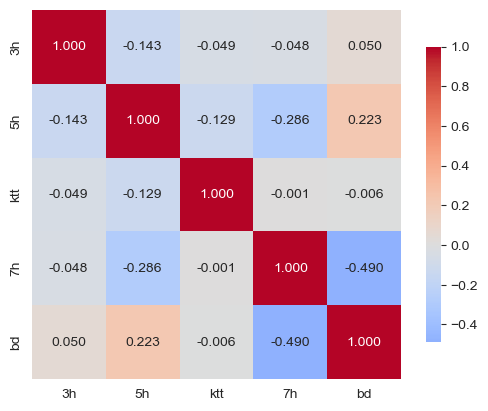

In [81]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f", square=True, cbar_kws={"shrink": .8}, center=0)
write_figure("caesura-correlations")

In [33]:
from itertools import product
caesura_count = len(all_caesuras)
occurrences = np.zeros((caesura_count+1, caesura_count+1))
matrix = np.zeros((caesura_count))
for idx, row in df[all_caesuras].iterrows():
    for c1 in all_caesuras:
        if row[c1].startswith("Just") and not any(row[c2].startswith("Just") for c2 in all_caesuras if c2 != c1):
            i = all_caesuras.index(c1)
            matrix[i] += 1
    for c1, c2 in product(all_caesuras, all_caesuras):
        if c1 == c2:
            continue
        i1, i2 = all_caesuras.index(c1), all_caesuras.index(c2)
        if row[c1].startswith("Just") and row[c2].startswith("Just"):
            occurrences[i1, i2] += 1
occurrences[-1,:-1] = matrix
occurrences[:-1,-1] = matrix
occurrences = occurrences.astype(int)
df_occ = pd.DataFrame(occurrences, index=all_caesuras + ["keine"], columns=all_caesuras + ["keine"])

In [34]:
df_tril = df_occ.where(np.tril(np.ones(df_occ.shape), k=-1).astype(bool))
pd.set_option("styler.format.precision", 0)
write_table(df_tril, "cooccurrences", caption="Häufigkeit des gemeinsamen Auftretens von Verseinschnitten")
df_occ
#df_tril.style.format(precision=0)

,3h,5h,7h,bd,keine
3h,0,1208,992,987,32
5h,1208,0,1219,1428,60
7h,992,1219,0,670,124
bd,987,1428,670,0,13
keine,32,60,124,13,0


In [35]:
df

,book,verse,text,words,syllables,scansion,3h,5h,ktt,7h,pqt,bd,metre,metreConflict,stress,stressConflict,weight,weightConflict
0,1,1,"iau sauléle vėl atkópdămă buddĭnŏ svieta,",6,14,SSSDDS,Nothing,Just Unmarked,Nothing,Nothing,Nothing,Just Unmarked,×××××××⏑⏑×⏑⏑××,0,×⏑–⏑×⏑–⏑⏑×××××,0,–––⏑–––⏑⏑–⏑⏑–⏑,0
1,1,2,ir žiemôs šaltôs trusùs pargráudămă juok...,6,13,SSSSDS,Just Unmarked,Just Unmarked,Nothing,Just Unmarked,Nothing,Nothing,×××××××××⏑⏑××,0,×⏑–⏑–⏑–⏑–⏑⏑××,0,–––––⏑–––⏑⏑––,0
2,1,3,šalčû prámonės sŭ lĕdaìs sugaištĭ păga...,6,14,SSDSDS,Nothing,Just Unmarked,Just Unmarked,Just Unmarked,Nothing,Nothing,×××××⏑⏑×××⏑⏑××,0,⏑––⏑⏑×⏑–×××⏑–⏑,2,–––⏑–⏑⏑–⏑–⏑⏑–⏑,0
3,1,4,ir puttódams sniegs vissùr i̷ niekă̷ păvirto.,7,13,SSSSDS,Nothing,Just Unmarked,Nothing,Just Unmarked,Nothing,Just Unmarked,×××××××××⏑⏑××,0,×⏑–⏑×⏑–××××××,0,––––––––––⏑–⏑,1
4,1,5,"tuo laukùs oraì drungnì gaivi̷dămĭ glóstė,",6,13,SSSSDS,Just Unmarked,Just Unmarked,Nothing,Just Unmarked,Nothing,Nothing,×××××××××⏑⏑××,0,×⏑–⏑–⏑–××××–⏑,0,–––⏑––⏑––⏑⏑––,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963,4,678,ìr tăvŏ mìslys neìgĭ bĕdùgnei mùms pa...,7,15,DSDSDS,Nothing,Nothing,Just Unmarked,Nothing,Nothing,Just Unmarked,×⏑⏑×××⏑⏑×××⏑⏑××,0,–××–⏑–⏑⏑–⏑–⏑⏑–⏑,0,–⏑⏑⏑––⏑⏑⏑––⏑⏑–⏑,2
2964,4,679,kàd mes kàrtais pergileý păsĭdrąsĭnę̆ ...,6,14,SSSDDS,Nothing,Nothing,Nothing,Just Unmarked,Nothing,Nothing,×××××××⏑⏑×⏑⏑××,0,–×–⏑⏑⏑–×××××–⏑,1,–––––⏑–⏑⏑–⏑–––,1
2965,4,680,"taìgĭ, tė̆tùtĭ, tŏliaùs už kóžną reì...",7,15,DDSSDS,Nothing,Just Unmarked,Nothing,Nothing,Nothing,Just Unmarked,×⏑⏑×⏑⏑×××××⏑⏑××,0,–⏑⏑–⏑⏑–×–⏑–⏑⏑–⏑,0,–⏑–⏑⏑⏑–––––⏑––⏑,3
2966,4,681,"rúpįk tėviškay, kad vėl jau vásără ràsis",7,13,SSSSDS,Nothing,Just Marked,Nothing,Just Unmarked,Nothing,Just Unmarked,×××××××××⏑⏑××,0,–⏑××××××–⏑⏑–⏑,0,–––⏑–––––⏑⏑⏑–,1


In [36]:
df_copy = df
for caesura in all_caesuras:
    df_copy[caesura] = df_copy[caesura].map(lambda x: x.startswith("Just"))
df_caesura_combinations = df_copy.groupby(all_caesuras).size().sort_values(ascending=False)
df_caesura_combinations.index = df_caesura_combinations.index.map(lambda caesuras: "+".join(caesura for caesura, is_present in zip(all_caesuras, caesuras) if is_present))
df_caesura_combinations = pd.DataFrame(df_caesura_combinations, columns=["Anzahl Verse"])
write_table(df_caesura_combinations, "caesura-combinations", caption="Häufigkeit der Kombinationen aus allen Verseinschnitten")
df_caesura_combinations

,Anzahl Verse
3h+5h+bd,579
5h+7h,396
5h+bd,379
3h+5h+7h,353
3h+7h,264
5h+7h+bd,240
3h+5h+7h+bd,230
3h+7h+bd,145
7h,124
5h,60
